In [1]:
from pyspark.sql import SparkSession

# creating a spark session
spark = SparkSession.builder \
    .appName("Movies Reccoss System") \
    .getOrCreate()

24/05/07 12:04:22 WARN Utils: Your hostname, Palaks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.98 instead (on interface en0)
24/05/07 12:04:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/07 12:04:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# loading dataset
df = spark.read.csv("/Users/palak/Downloads/TMDB_all_movies.csv", header=True, inferSchema=True)
df.show(5)

+---+--------------------+------------+----------+--------+------------+----------+-------+----------+---------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+--------------------+--------------------+------------------+
| id|               title|vote_average|vote_count|  status|release_date|   revenue|runtime|    budget|  imdb_id|original_language|      original_title|            overview|          popularity|             tagline|              genres|production_companies|production_countries|    spoken_languages|                cast|            director|director_of_photography|             writers|           producers|    music_composer|
+---+--------------------+------------+----------+--------+------------+----------+-------+----------+---------+-----------------+------------------

In [3]:
# printing schema for data types and column names
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- status: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- director: string (nullable = true)
 |-- director_of_photography: string (nullable = true)
 |-- writers: string (nullable = true)
 |-- producers: string (n

24/05/07 12:04:37 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
# total number of rows in the dataset
print("Number of rows:", df.count())

Number of rows: 930297


In [5]:
# summary statistics
df.describe().show()

24/05/07 12:04:49 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+------------------+--------------+--------------------+-----------------------------------+------------------+------------------+--------------------+--------------------+--------------------------------+--------------------+--------------------+-----------------------------+------------------+--------------------+----------------------+
|summary|               id|               title|        vote_average|          vote_count|              status|        release_date|             revenue|             runtime|              budget|          imdb_id| original_language|original_title|            overview|                         popularity|           tagline|            genres|production_companies|production_countries|                spoken_languages|                cast|         

In [6]:
# checking for missing values
for column in df.columns:
    missing_count = df.filter(df[column].isNull()).count()
    if missing_count > 0:
        print(f"Number of missing values in {column}: {missing_count}")

Number of missing values in title: 599


Number of missing values in vote_average: 868


Number of missing values in vote_count: 876


Number of missing values in status: 919


Number of missing values in release_date: 89839


Number of missing values in revenue: 953


Number of missing values in runtime: 943


Number of missing values in budget: 919


Number of missing values in imdb_id: 369891


Number of missing values in original_language: 1060


Number of missing values in original_title: 1074


Number of missing values in overview: 157219


Number of missing values in popularity: 1639


Number of missing values in tagline: 753386


Number of missing values in genres: 266989


Number of missing values in production_companies: 485122


Number of missing values in production_countries: 355662


Number of missing values in spoken_languages: 354561


Number of missing values in cast: 307418


Number of missing values in director: 170615


Number of missing values in director_of_photography: 686682


Number of missing values in writers: 476397


Number of missing values in producers: 627009


Number of missing values in music_composer: 822347


In [7]:
# dropping irrelevant columns
columns_to_drop = ['tagline', 'music_composer', 'production_companies',  'producers', 'writers', 'director_of_photography']
df = df.drop(*columns_to_drop)

# updated DataFrame schema
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- status: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- director: string (nullable = true)



In [8]:
from pyspark.sql.functions import col

numerical_columns = ['vote_average', 'vote_count', 'revenue', 'runtime', 'budget', 'popularity']
for column in numerical_columns:
    df = df.withColumn(column, col(column).cast('float'))

In [9]:
from pyspark.sql.functions import expr

for column in numerical_columns:
    median_val = df.approxQuantile(column, [0.5], 0.01)[0]
    df = df.na.fill({column: median_val})

In [10]:
from pyspark.sql.functions import first

categorical_columns = ['title', 'status', 'original_language', 'original_title', 'overview', 'genres', 'production_countries', 'spoken_languages', 'cast', 'director']

# Example for 'original_language'
# Iterate over each categorical column
for column in categorical_columns:
    # Find the most frequent value (mode) for the column
    most_common = df.groupBy(column).count().orderBy(col("count").desc()).first()[0]
    
    # Fill missing values in the column with the most frequent value
    if most_common is not None:  # Check if the column has at least one non-null value
        df = df.na.fill({column: most_common})
    else:
        # Optionally handle columns where all values are missing or where there's no clear mode
        df = df.na.fill({column: 'Unknown'})  # Assuming 'Unknown' as a placeholder

# Show some data to confirm changes
df.show()

+---+--------------------+------------+----------+--------+------------+-----------+-------+---------+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+-----------------------+--------------------+--------------------+
| id|               title|vote_average|vote_count|  status|release_date|    revenue|runtime|   budget|  imdb_id|original_language|      original_title|            overview|popularity|              genres|production_countries|       spoken_languages|                cast|            director|
+---+--------------------+------------+----------+--------+------------+-----------+-------+---------+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+-----------------------+--------------------+--------------------+
|  2|               Ariel|         7.1|     309.0|Released|  1988-10-21|        0.0|   73.0|      0.0|tt0094675|            

In [11]:
from pyspark.sql.functions import col

# printing distribution of numerical features like 'vote_average' and 'budget'
num_columns = ['vote_average', 'budget', 'revenue', 'runtime']
for column in num_columns:
    df.select(column).describe().show()

+-------+------------------+
|summary|      vote_average|
+-------+------------------+
|  count|            930297|
|   mean|2.2410018167626307|
| stddev|3.1242573440650556|
|    min|               0.0|
|    max|            17.287|
+-------+------------------+



+-------+-----------------+
|summary|           budget|
+-------+-----------------+
|  count|           930297|
|   mean|322878.5736245468|
| stddev|5121834.967314752|
|    min|              0.0|
|    max|      6.4565466E8|
+-------+-----------------+



+-------+--------------------+
|summary|             revenue|
+-------+--------------------+
|  count|              930297|
|   mean|    808810.969344448|
| stddev|1.8265463620730754E7|
|    min|               -12.0|
|    max|               3.0E9|
+-------+--------------------+



+-------+------------------+
|summary|           runtime|
+-------+------------------+
|  count|            930297|
|   mean|46.566369165975914|
| stddev| 58.39949621896666|
|    min|               0.0|
|    max|           14400.0|
+-------+------------------+



# EDA

In [1]:
import pandas as pd
df = pd.read_csv("/Users/palak/Downloads/TMDB_all_movies.csv")

In [2]:
import pandas as pd

# cleaning genres column, exploding genres to check the distribution of different genres
df['genre'] = df['genres'].str.split(',\s*')
df_exploded = df.explode('genre')
genre_counts = df_exploded['genre'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']
genre_counts.sort_values('count', ascending=False, inplace=True)
print(genre_counts)

# printing top directors
director_counts = df['director'].value_counts().reset_index().head(10)
director_counts.columns = ['director', 'count']
print(director_counts)

              genre   count
0             Drama  220799
1       Documentary  161176
2            Comedy  135458
3         Animation   55337
4            Horror   51309
5           Romance   50467
6             Music   48388
7          Thriller   45226
8            Action   43017
9             Crime   33059
10           Family   27367
11         TV Movie   25082
12        Adventure   22652
13          Fantasy   21498
14  Science Fiction   20438
15          Mystery   19296
16          History   16758
17              War   10604
18          Western    8673
              director  count
0       Dave Fleischer    524
1        D.W. Griffith    439
2  Gilbert M. Anderson    373
3           Kevin Dunn    373
4        Stan Brakhage    372
5       Gérard Courant    359
6      Seymour Kneitel    326
7     Alexandre Promio    322
8         Friz Freleng    268
9          Chuck Jones    257


In [3]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# downloading the stopwords dataset
nltk.download('punkt')
nltk.download('stopwords')

# tokenizing the 'overview' column
df['words'] = df['overview'].apply(lambda x: word_tokenize(str(x)))

# removing stop words
stop_words = set(stopwords.words('english'))
df['filtered'] = df['words'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

# printing filtered words
print(df[['filtered']].head())

[nltk_data] Downloading package punkt to /Users/palak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/palak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                            filtered
0  [coal, mine, works, closes, father, commits, s...
1  [Nikander, ,, rubbish, collector, would-be, en...
2  ['s, Ted, Bellhop, 's, first, night, job, ...,...
3  [Four, young, friends, ,, taking, shortcut, en...
4  [Timo, Novotny, labels, new, project, experime...


In [4]:
# printing the first few rows of the dataset
print(df.head())

# summary of the DataFrame
print(df.info())

# Summary statistics for numerical columns
print(df.describe())

# missing values
print(df.isnull().sum())

   id                             title  vote_average  vote_count    status  \
0   2                             Ariel         7.100         309  Released   
1   3               Shadows in Paradise         7.288         349  Released   
2   5                        Four Rooms         5.800        2555  Released   
3   6                    Judgment Night         6.508         321  Released   
4   8  Life in Loops (A Megacities RMX)         7.500          27  Released   

  release_date     revenue  runtime      budget    imdb_id  ...  \
0   1988-10-21         0.0       73         0.0  tt0094675  ...   
1   1986-10-17         0.0       74         0.0  tt0092149  ...   
2   1995-12-09   4257354.0       98   4000000.0  tt0113101  ...   
3   1993-10-15  12136938.0      109  21000000.0  tt0107286  ...   
4   2006-01-01         0.0       80     42000.0  tt0825671  ...   

                         spoken_languages  \
0                                   suomi   
1                 suomi, English

In [5]:
# dropping irrelevant columns
columns_to_drop = ['tagline', 'music_composer', 'production_companies',  'producers', 'writers', 'director_of_photography']
df = df.drop(columns=columns_to_drop)

In [6]:
# Fill missing values
categorical_columns = ['title', 'status', 'original_language', 'original_title', 'overview', 'genres', 'production_countries', 'spoken_languages', 'cast', 'director']
numerical_columns = ['vote_average', 'vote_count', 'revenue', 'runtime', 'budget', 'popularity']

# Filling categorical columns with the most frequent values
for column in categorical_columns:
    most_common = df[column].mode()[0]
    df[column] = df[column].fillna(most_common)

# Filling numerical columns with the median
for column in numerical_columns:
    median_val = df[column].median()
    df[column] = df[column].fillna(median_val)

# Re-check for missing values
print(df.isnull().sum())

id                           0
title                        0
vote_average                 0
vote_count                   0
status                       0
release_date             88920
revenue                      0
runtime                      0
budget                       0
imdb_id                 368926
original_language            0
original_title               0
overview                     0
popularity                   0
genres                       0
production_countries         0
spoken_languages             0
cast                         0
director                     0
genre                   269473
words                        0
filtered                     0
dtype: int64


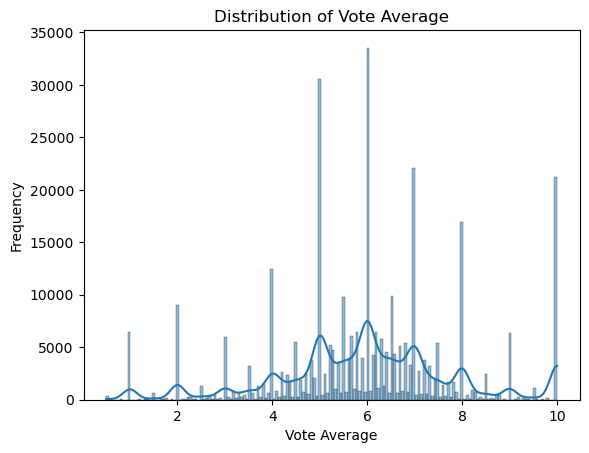

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Remove entries where 'vote_average' is 0.0
df = df[df['vote_average'] != 0.0]

# Example: Visualizing the distribution of 'vote_average'
sns.histplot(df['vote_average'], kde=True)
plt.title('Distribution of Vote Average')
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.show()

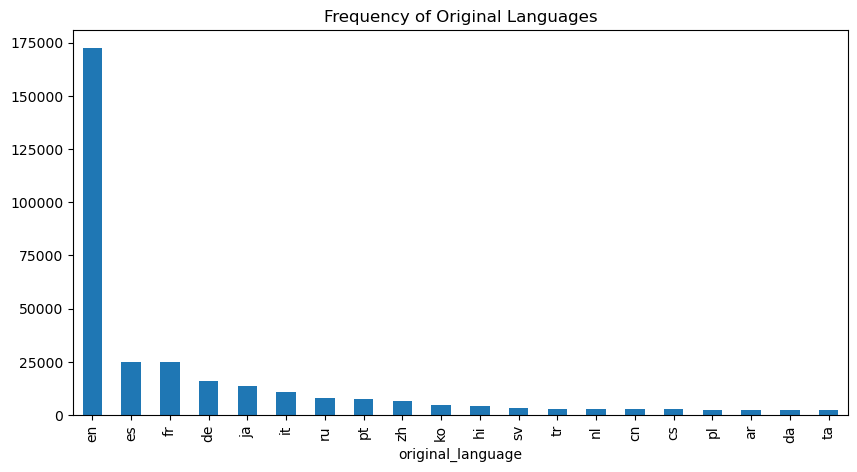

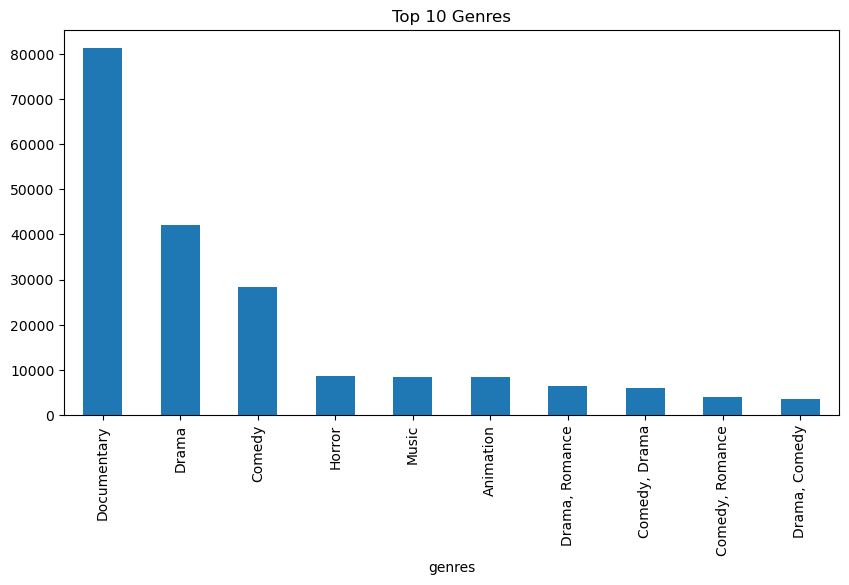

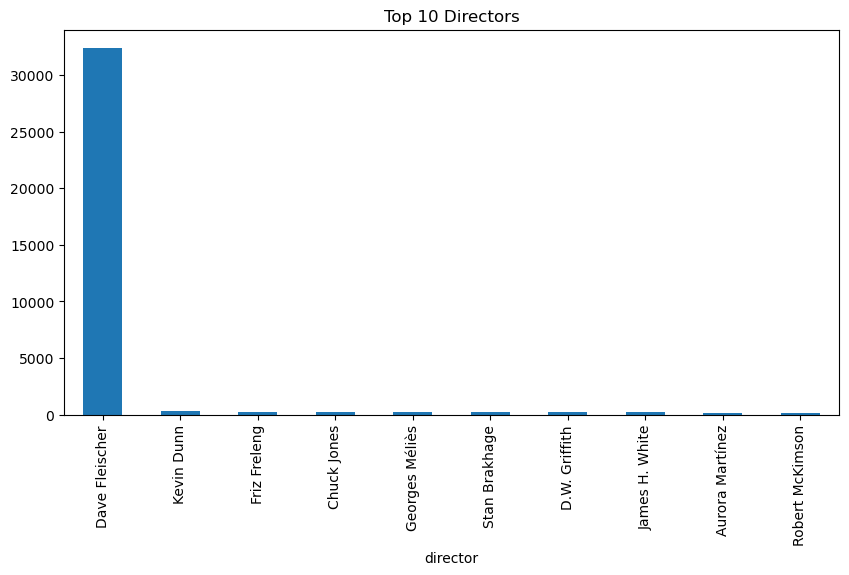

In [12]:
# frequency of categories in 'original_language'
df['original_language'].value_counts().head(20).plot(kind='bar', figsize=(10, 5))
plt.title('Frequency of Original Languages')
plt.show()

# analyzing the 'genres' column
df['genres'].value_counts().head(10).plot(kind='bar', figsize=(10, 5))
plt.title('Top 10 Genres')
plt.show()

# analyzing the 'director' column
df['director'].value_counts().head(10).plot(kind='bar', figsize=(10, 5))
plt.title('Top 10 Directors')
plt.show()

We see too much difference between the directors, this could be due to a biased dataset or the column had missing values and we imputed it with most frequent.

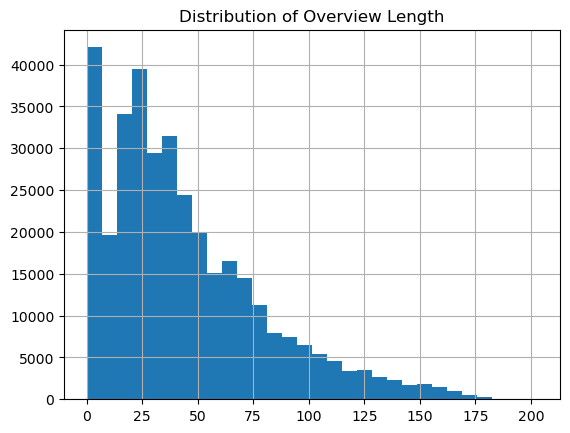

In [13]:
# length of 'overview' text
df['overview_length'] = df['overview'].apply(lambda x: len(str(x).split()))
df['overview_length'].hist(bins=30)
plt.title('Distribution of Overview Length')
plt.show()

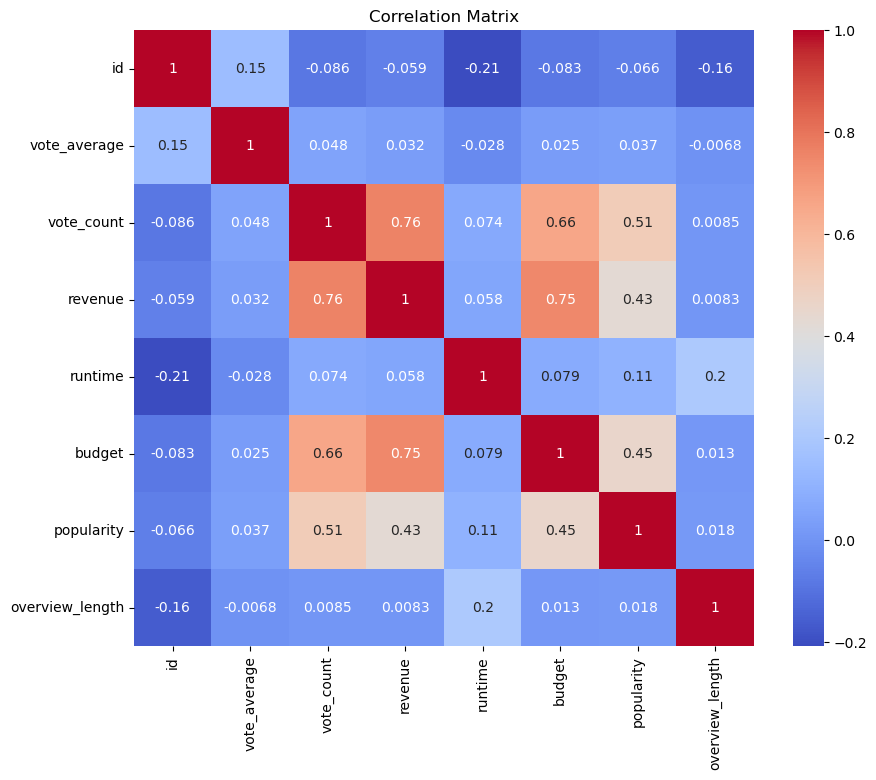

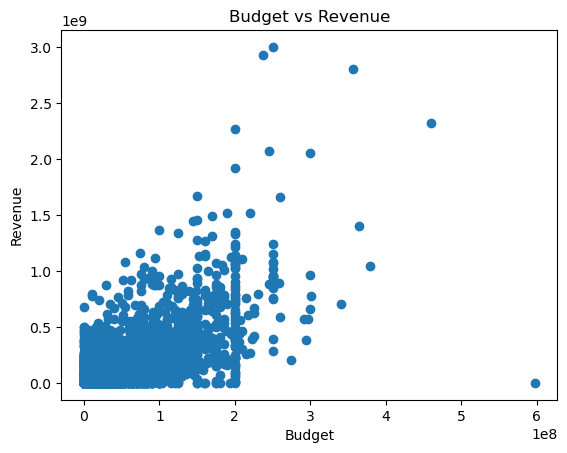

/Users/palak/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


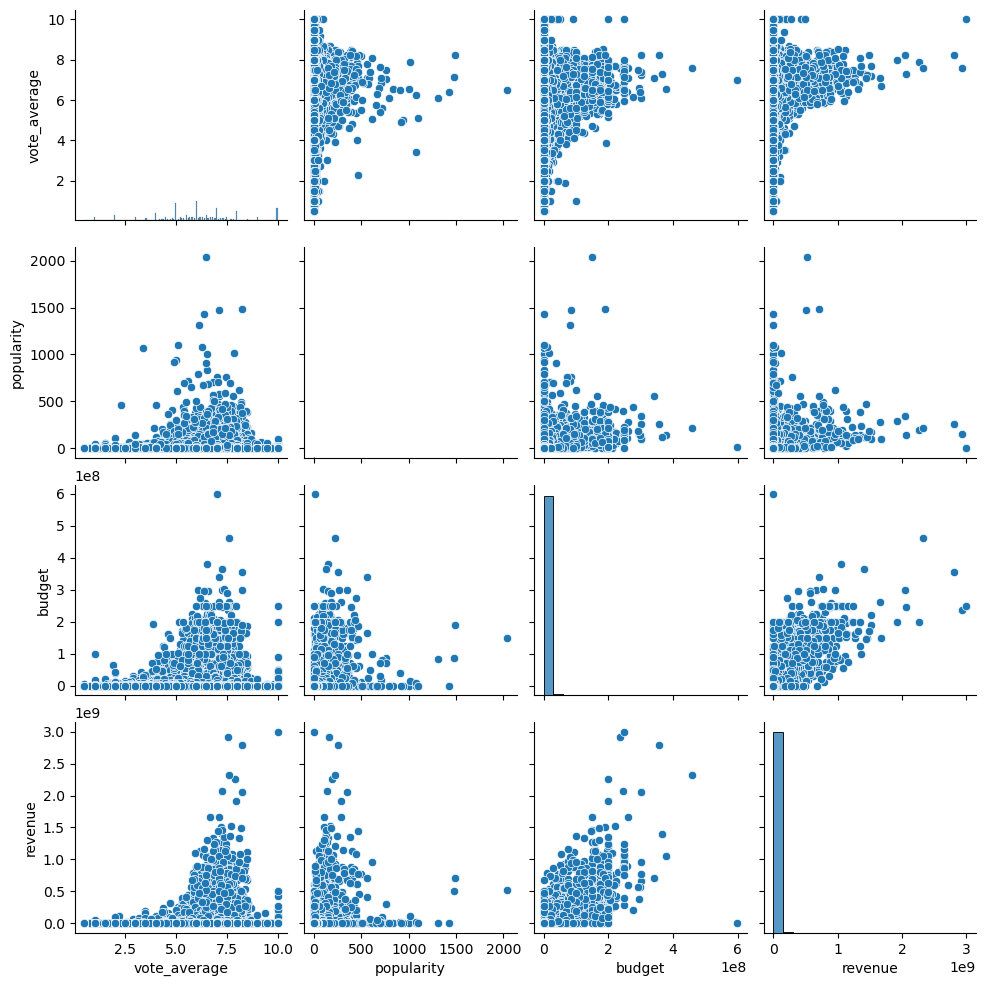

In [15]:
import numpy as np

# correlation matrix heatmap
corr = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# scatter plot of budget vs revenue
plt.scatter(df['budget'], df['revenue'])
plt.title('Budget vs Revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.show()

# pairplot for selected features
sns.pairplot(df[['vote_average', 'popularity', 'budget', 'revenue']])
plt.show()

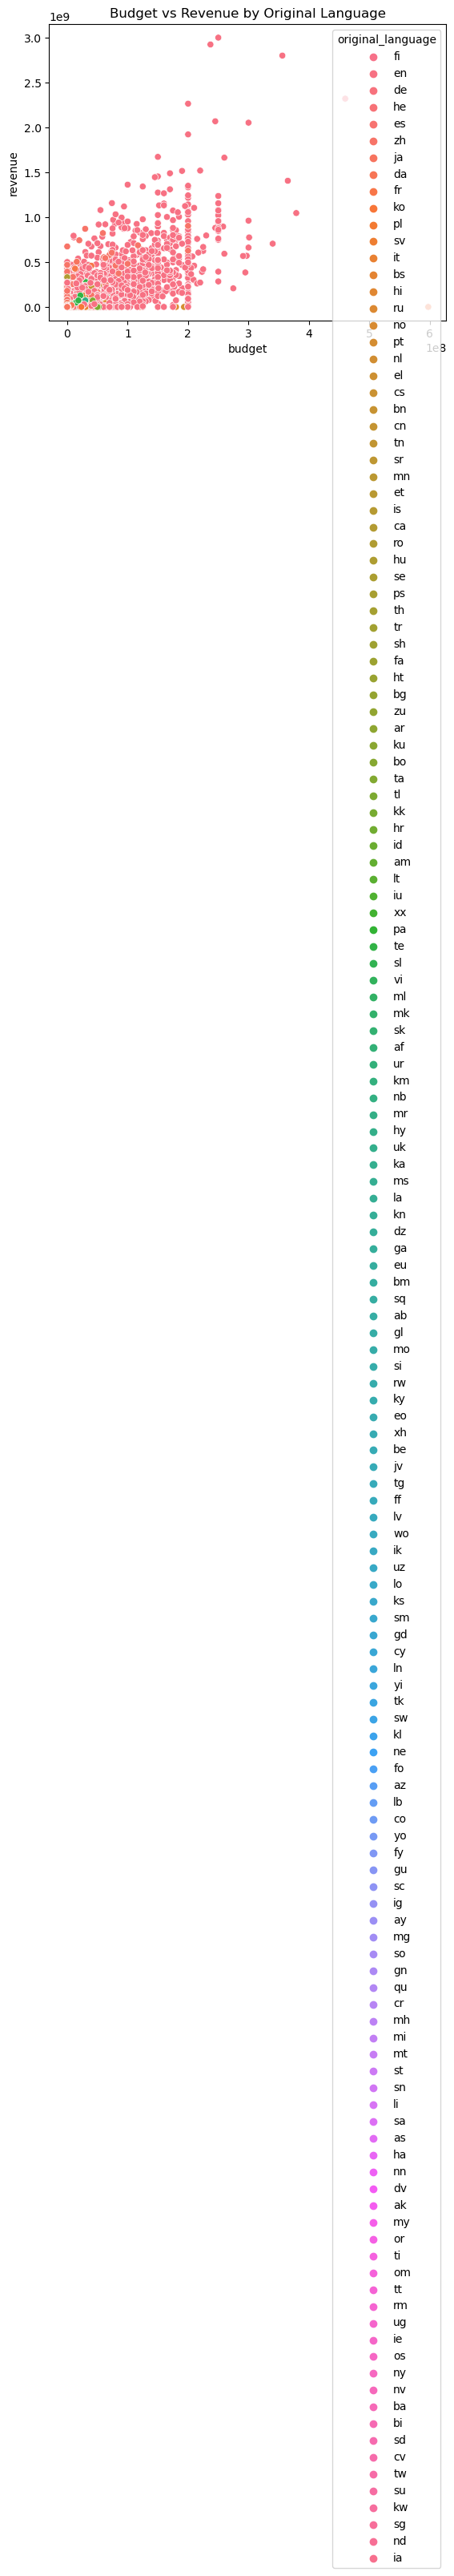

In [16]:
# plotting budget vs revenue by original language
sns.scatterplot(x='budget', y='revenue', hue='original_language', data=df)
plt.title('Budget vs Revenue by Original Language')
plt.show()

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# converting release_date to datetime format
df['release_date'] = pd.to_datetime(df['release_date'])

# extracting year and creating a new column
df['release_year'] = df['release_date'].dt.year

In [18]:
# filtered data to the past 25 completed yrs (1998 through 2023)
df1 = df.loc[(df.release_year>=1998 ) & (df.release_year<=2023)]

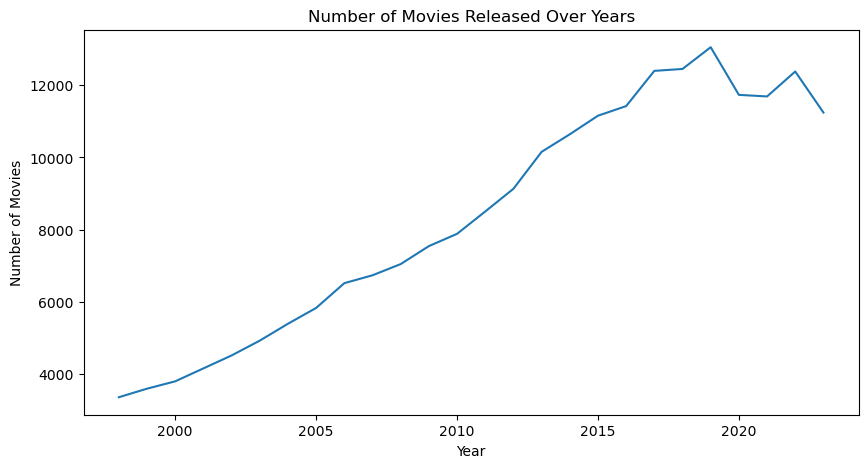

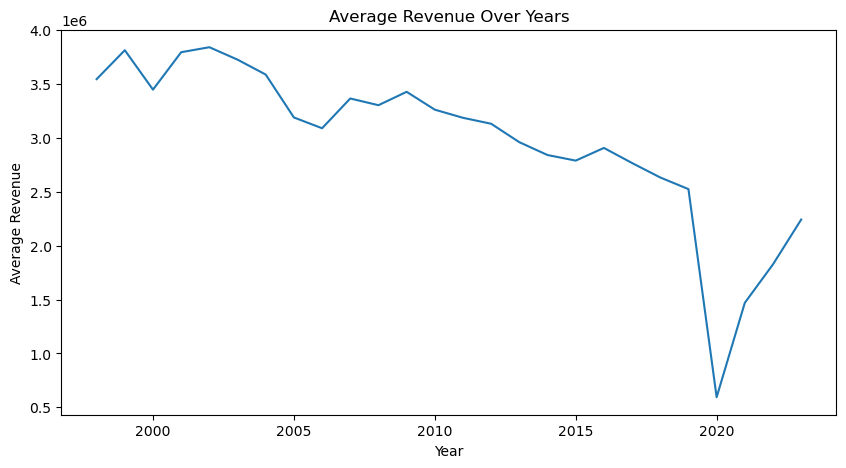

In [19]:
# plotting number of movies released per year
df1['release_year'].value_counts().sort_index().plot(kind='line', figsize=(10, 5))
plt.title('Number of Movies Released Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

# average revenue over the years
df1.groupby('release_year')['revenue'].mean().plot(kind='line', figsize=(10, 5))
plt.title('Average Revenue Over Years')
plt.xlabel('Year')
plt.ylabel('Average Revenue')
plt.show()

we can see that there is a dip in 2020 for the revenue average in that year, this could possibly be because of the COVID pandemic, due to which there were no movies released in that year and no box office collection because of closed movie halls.

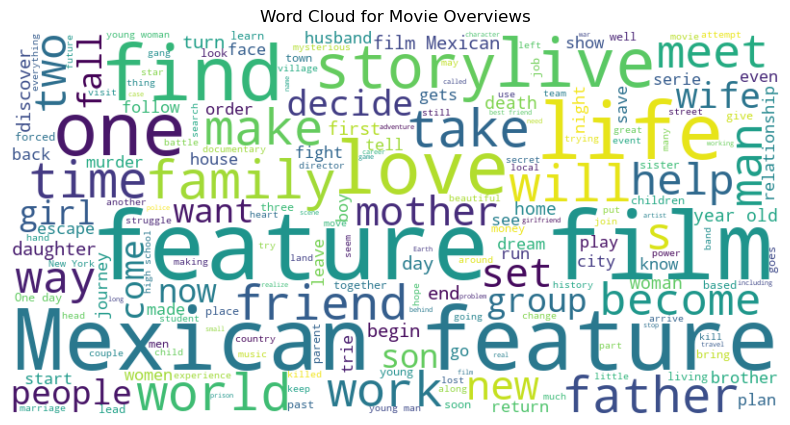

In [20]:
from wordcloud import WordCloud

# generating a word cloud for overviews
text = ' '.join(df['overview'].fillna('').values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Movie Overviews')
plt.show()

# Machine Learning for prediction

/Users/palak/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/palak/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


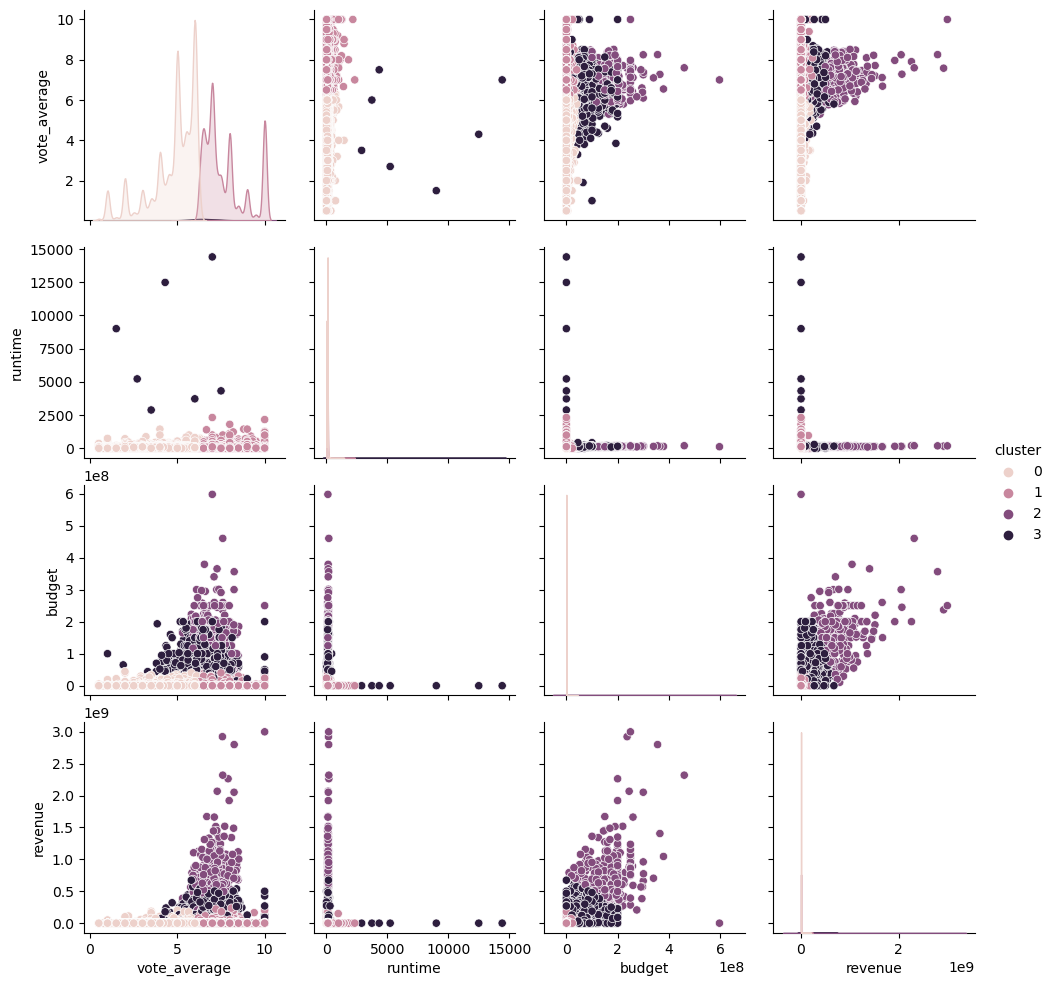

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# selecting numerical columns for clustering
numeric_data = df[['vote_average', 'runtime', 'budget', 'revenue']].dropna()

# scaling data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(scaled_data)
numeric_data['cluster'] = kmeans.labels_

# plotting clusters
sns.pairplot(numeric_data, hue='cluster')
plt.show()

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# features: 'budget', 'runtime', 'revenue'
features = ['budget', 'runtime', 'revenue']

# handle missing values by dropping or imputing
#df.dropna(subset=features + ['vote_average'], inplace=True)

df[features] = df[features].fillna(df[features].median())

# Feature scaling (if needed)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Create feature matrix X and target vector y
X = df[features]
y = df['vote_average']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Print the sizes of the train and test datasets
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (278524, 3)
Test size: (69631, 3)


### Logistic Regression

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Converting vote_average to a binary variable
threshold = df['vote_average'].median()
df['vote_average_high_low'] = (df['vote_average'] > threshold).astype(int)

# Feature selection and preprocessing
features = df[['budget', 'runtime']]
target = df['vote_average_high_low']

# Data scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Model building
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicting
predictions = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.5590182533641626
Confusion Matrix:
[[38082   395]
 [30311   843]]


### Decision Tree

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Converting vote_average to a binary variable
threshold = df['vote_average'].median()
df['vote_average_high_low'] = (df['vote_average'] > threshold).astype(int)

# Feature selection and preprocessing
features = df[['budget', 'runtime']]
target = df['vote_average_high_low']

# Data scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Model building
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

# Predicting
predictions = dtree.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.5813646220792463
Confusion Matrix:
[[31993  6484]
 [22666  8488]]


### Random Forest

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Converting vote_average to a binary variable
threshold = df['vote_average'].median()
df['vote_average_high_low'] = (df['vote_average'] > threshold).astype(int)

# Feature selection and preprocessing
features = df[['budget', 'runtime']]
target = df['vote_average_high_low']

# Data scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Model building
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

# Predicting
predictions = rfc.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.5837055334549267
Confusion Matrix:
[[31935  6542]
 [22445  8709]]


# Model Evaluation using Hyperparameter tuning

### Logistic Regession after hyperparameter tuning

In [27]:
from sklearn.model_selection import GridSearchCV

# Defining the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strengths
    'penalty': ['l1', 'l2'],  # Penalties (some solvers might not support all options)
    'solver': ['liblinear', 'saga']  # Solvers
}
# LogisticRegression model
log_reg = LogisticRegression()

# GridSearchCV object
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [28]:
# best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best cross-validation score (accuracy):", best_score)

# best estimator to make predictions
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Evaluating the predictions
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print(f"Test Accuracy: {accuracy}")
print("Test Confusion Matrix:")
print(conf_matrix)

Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score (accuracy): 0.5570435568604812
Test Accuracy: 0.5590182533641626
Test Confusion Matrix:
[[38082   395]
 [30311   843]]


### Decision Tree after hyperparameter tuning

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Create a DecisionTreeClassifier model
dtree = DecisionTreeClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=dtree, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             scoring='accuracy', verbose=1)

In [31]:
# best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best cross-validation score (accuracy):", best_score)

# best estimator to make predictions
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Evaluating the predictions
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print(f"Test Accuracy: {accuracy}")
print("Test Confusion Matrix:")
print(conf_matrix)

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score (accuracy): 0.5878057260566234
Test Accuracy: 0.5878272608464621
Test Confusion Matrix:
[[31944  6533]
 [22167  8987]]


### Random forest after hyperparameter tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Defining the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']  
}

# RandomForestClassifier model
rfc = RandomForestClassifier()

# GridSearchCV object
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [ ]:
# best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best cross-validation score (accuracy):", best_score)

# best estimator to make predictions
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Evaluating the predictions
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print(f"Test Accuracy: {accuracy}")
print("Test Confusion Matrix:")
print(conf_matrix)

### Neural Networks

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Neural Network Test Accuracy: {test_acc}")

Epoch 1/10


/Users/palak/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6964/6964 ━━━━━━━━━━━━━━━━━━━━ 5s 564us/step - accuracy: 0.0181 - loss: -2249406.5000 - val_accuracy: 0.0189 - val_loss: -27444068.0000
Epoch 2/10
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 4s 587us/step - accuracy: 0.0184 - loss: -50386464.0000 - val_accuracy: 0.0189 - val_loss: -153114352.0000
Epoch 3/10
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 4s 547us/step - accuracy: 0.0183 - loss: -210706112.0000 - val_accuracy: 0.0189 - val_loss: -431225728.0000
Epoch 4/10
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 4s 555us/step - accuracy: 0.0184 - loss: -537282624.0000 - val_accuracy: 0.0189 - val_loss: -915042240.0000
Epoch 5/10
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 4s 552us/step - accuracy: 0.0183 - loss: -1082805504.0000 - val_accuracy: 0.0189 - val_loss: -1655491072.0000
Epoch 6/10
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 4s 549us/step - accuracy: 0.0181 - loss: -1899684480.0000 - val_accuracy: 0.0189 - val_loss: -2704728576.0000
Epoch 7/10
6964/6964 ━━━━━━━━━━━━━━━━━━━━ 4s 552us/step - accuracy: 0.0180 - loss: -3040063232.0000 - val_accur